# Stage 2.1 — EDA time-series (Block C)

This notebook explores time-series behavior across the Stage 2 canonical slices:
- `df_all` for quality/coverage context and artifact visibility
- `df_strict` for default daily signal analysis
- `df_sleep` for sleep-specific timeseries

Goal of Block C:
- inspect trends, shifts, and anomaly periods over time
- stay quality-aware while interpreting signals
- prepare hypotheses and stronger chart candidates for later Stage 2 sections

Set `SAVE_FIGS=True` to export figures to `reports/figures/timeseries/` (local, gitignored).


In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from garmin_analytics.eda import prepare as eda_prepare
from garmin_analytics.eda.plots_common import maybe_savefig as eda_maybe_savefig, repo_root as eda_repo_root
from garmin_analytics.eda.sleep_plots import (
    plot_sleep_duration,
    plot_sleep_duration_scored,
    plot_sleep_intervals,
    plot_sleep_respiration,
    plot_sleep_scores,
    plot_sleep_spo2,
    plot_sleep_stage_fractions,
    plot_sleep_stage_hours,
    plot_sleep_stress,
)

repo_root = eda_repo_root(Path.cwd())

SAVE_FIGS: bool = False
FIG_DIR = repo_root / 'reports/figures/timeseries'
DPI = 150
FIG_FMT = "png"

RAW_ALPHA_DEFAULT = 0.30
RAW_ALPHA_DENSE = 0.25
RAW_LW = 0.8
ROLL_LW = 2.0
ROLL_ALPHA = 0.95

add_derived_features = eda_prepare.add_derived_features
build_eda_frames = eda_prepare.build_eda_frames
load_daily_sanitized = eda_prepare.load_daily_sanitized
load_quality = eda_prepare.load_quality

pd.set_option('display.max_columns', 120)


In [2]:
daily_sanitized_path = repo_root / 'data/processed/daily_sanitized.parquet'
daily_fallback_path = repo_root / 'data/processed/daily.parquet'
quality_path = repo_root / 'data/processed/daily_quality.parquet'

daily_path = daily_sanitized_path if daily_sanitized_path.exists() else daily_fallback_path
if not daily_path.exists():
    raise FileNotFoundError(f'Daily parquet not found: {daily_path}')
if not quality_path.exists():
    raise FileNotFoundError(f'Quality parquet not found: {quality_path}')

daily_df = load_daily_sanitized(daily_path)
quality_df = load_quality(quality_path)

frames = build_eda_frames(daily_df, quality_df, strict_min_score=4, loose_min_score=3)
df_all = add_derived_features(frames['df_all'])
df_strict = add_derived_features(frames['df_strict'])
df_sleep = add_derived_features(frames['df_sleep'])

# Explicit Stage 2.1 filters (same logic, re-applied for clarity)
for req_col in ['valid_day_strict', 'corrupted_stress_only_day', 'has_sleep']:
    if req_col not in df_all.columns:
        raise KeyError(f'Missing required quality column: {req_col}')

df_strict = df_all[(df_all['valid_day_strict'] == True) & (df_all['corrupted_stress_only_day'] == False)].copy()
df_sleep = df_all[(df_all['has_sleep'] == True) & (df_all['corrupted_stress_only_day'] == False)].copy()

for _df in [df_all, df_strict, df_sleep]:
    _df.sort_values('calendarDate', inplace=True)

print('Repo root:', repo_root)
print('Daily input:', daily_path)
print('Quality input:', quality_path)

Repo root: /Users/abatrakov/Documents/FUN/wearable-analytics
Daily input: /Users/abatrakov/Documents/FUN/wearable-analytics/data/processed/daily_sanitized.parquet
Quality input: /Users/abatrakov/Documents/FUN/wearable-analytics/data/processed/daily_quality.parquet


In [3]:
summary_rows = []
for name, frame in [('df_all', df_all), ('df_strict', df_strict), ('df_sleep', df_sleep)]:
    summary_rows.append({
        'slice': name,
        'rows': len(frame),
        'date_min': frame['calendarDate'].min(),
        'date_max': frame['calendarDate'].max(),
    })

timeseries_summary = pd.DataFrame(summary_rows)
timeseries_summary

,slice,rows,date_min,date_max
0,df_all,580,2023-05-26,2026-02-05
1,df_strict,525,2023-05-26,2026-02-05
2,df_sleep,474,2023-05-27,2026-02-05


In [4]:
def maybe_save(fig, name: str):
    """
    Save a matplotlib figure to FIG_DIR if SAVE_FIGS is True.
    Name should be a short slug (no spaces). The function creates FIG_DIR.
    """
    eda_maybe_savefig(
        fig,
        name,
        save_figs=SAVE_FIGS,
        fig_dir=FIG_DIR,
        dpi=DPI,
        fmt=FIG_FMT,
    )

def plot_ts_with_gaps(ax, df, date_col, y_col, label=None, rolling_days=None):
    """
    Plot y_col vs date_col but break lines across missing dates by reindexing to daily frequency.
    Uses a full daily date_range from min to max, inserts NaN for missing days.
    If rolling_days is provided, also plot rolling mean (on the reindexed daily series).
    Returns the reindexed series.
    """
    if date_col not in df.columns or y_col not in df.columns:
        raise KeyError(f"Missing required columns: {date_col}, {y_col}")

    tmp = df[[date_col, y_col]].copy()
    tmp[date_col] = pd.to_datetime(tmp[date_col], errors='coerce').dt.normalize()
    tmp[y_col] = pd.to_numeric(tmp[y_col], errors='coerce')
    tmp = tmp.dropna(subset=[date_col]).sort_values(date_col)

    if tmp.empty:
        return pd.Series(dtype=float)

    idx = pd.date_range(tmp[date_col].min(), tmp[date_col].max(), freq='D')
    s = tmp.set_index(date_col)[y_col].astype(float).reindex(idx)
    ax.plot(idx, s.values, label=label or y_col, lw=RAW_LW, alpha=RAW_ALPHA_DEFAULT)

    if rolling_days:
        min_periods = max(3, rolling_days // 2)
        roll = s.rolling(rolling_days, min_periods=min_periods).mean()
        ax.plot(idx, roll.values, label=f'{rolling_days}-day mean', lw=ROLL_LW, alpha=ROLL_ALPHA)

    return s

def _find_col(frame: pd.DataFrame, preferred: str, fallback: str | None = None) -> str | None:
    if preferred in frame.columns:
        return preferred
    if fallback is not None and fallback in frame.columns:
        return fallback
    return None

def _plot_line_with_roll(
    frame: pd.DataFrame,
    y_col: str,
    title: str,
    ylabel: str,
    rolling_window: int = 7,
    save_name: str | None = None,
 ) -> None:
    if y_col not in frame.columns or 'calendarDate' not in frame.columns:
        print(f'Skip: missing column {y_col} or calendarDate')
        return
    fig, ax = plt.subplots(figsize=(12, 4))
    series = plot_ts_with_gaps(
        ax,
        frame,
        'calendarDate',
        y_col,
        label=y_col,
        rolling_days=rolling_window,
    )
    if series.empty:
        print(f'Skip: no plottable data for {y_col}')
        plt.close(fig)
        return
    ax.set_title(title)
    ax.set_xlabel('calendarDate')
    ax.set_ylabel(ylabel)
    ax.legend()
    fig.tight_layout()
    if save_name is not None:
        maybe_save(fig, save_name)
    plt.show()

def _ts_numeric_frame(frame: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    required = ['calendarDate', *cols]
    tmp = frame[required].copy()
    tmp['calendarDate'] = pd.to_datetime(tmp['calendarDate'], errors='coerce').dt.normalize()
    for col in cols:
        tmp[col] = pd.to_numeric(tmp[col], errors='coerce')
    return tmp.dropna(subset=['calendarDate']).sort_values('calendarDate')


### Plot style convention (Block C)

- Raw daily series: thin line with moderate transparency (context)
- 7-day rolling mean: thicker line in the same hue (primary trend signal)
- Structured plots (stacked shares, score-colored points) may use custom styling when that better communicates the question


## Quality (context only)

This section is intentionally compact and acts as a lens for reading later signals.
Coverage/retention diagnostics and calendar heatmaps live in `01_eda_prepare.ipynb` (Block B).


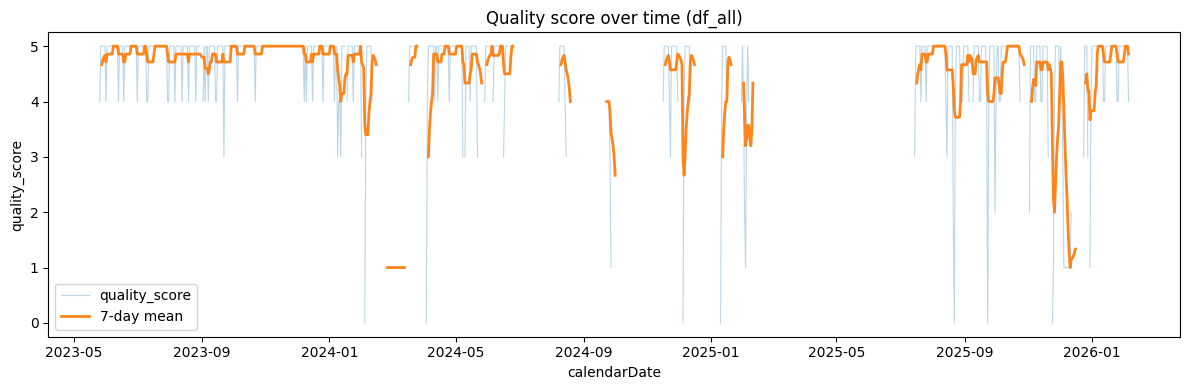

In [5]:
_plot_line_with_roll(df_all, 'quality_score', 'Quality score over time (df_all)', 'quality_score', save_name='quality_score')

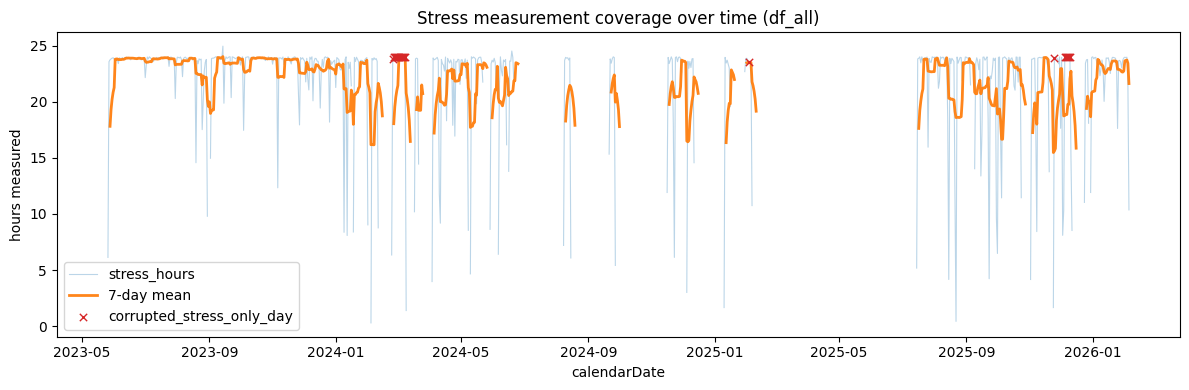

In [6]:
if 'stress_hours' not in df_all.columns:
    print('Skip: missing column stress_hours')
else:
    fig, ax = plt.subplots(figsize=(12, 4))
    stress_s = plot_ts_with_gaps(
        ax,
        df_all,
        'calendarDate',
        'stress_hours',
        label='stress_hours',
        rolling_days=7,
    )

    if 'corrupted_stress_only_day' in df_all.columns and not stress_s.empty:
        corrupted = df_all[df_all['corrupted_stress_only_day'].fillna(False).astype(bool)].copy()
        if not corrupted.empty:
            corrupted['calendarDate'] = pd.to_datetime(corrupted['calendarDate'], errors='coerce').dt.normalize()
            corrupted = corrupted.dropna(subset=['calendarDate'])
            y_corrupted = stress_s.reindex(corrupted['calendarDate'])
            ax.scatter(
                corrupted['calendarDate'],
                y_corrupted.values,
                s=28,
                marker='x',
                color='#d62728',
                linewidths=1.0,
                zorder=6,
                label='corrupted_stress_only_day',
            )

    ax.set_title('Stress measurement coverage over time (df_all)')
    ax.set_xlabel('calendarDate')
    ax.set_ylabel('hours measured')
    ax.legend()
    fig.tight_layout()
    maybe_save(fig, 'stress_hours_all')
    plt.show()


### Quality findings

- `quality_score` and `stress_hours` act as context layers for later sections (especially around coverage gaps and partial periods).
- `corrupted_stress_only_day` markers are shown as artifact flags only and should not be interpreted as physiological events.


## Activity / mobility

Focus: movement volume, movement intensity proxies, and simple derived mobility indicators.
Default slice is `df_strict` (quality-aware daily analysis).


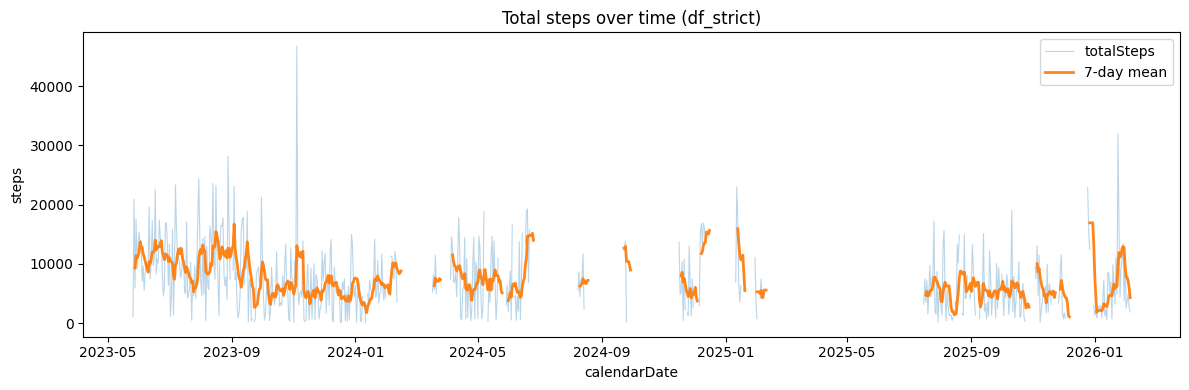

In [7]:
_plot_line_with_roll(df_strict, 'totalSteps', 'Total steps over time (df_strict)', 'steps', save_name='steps_strict')

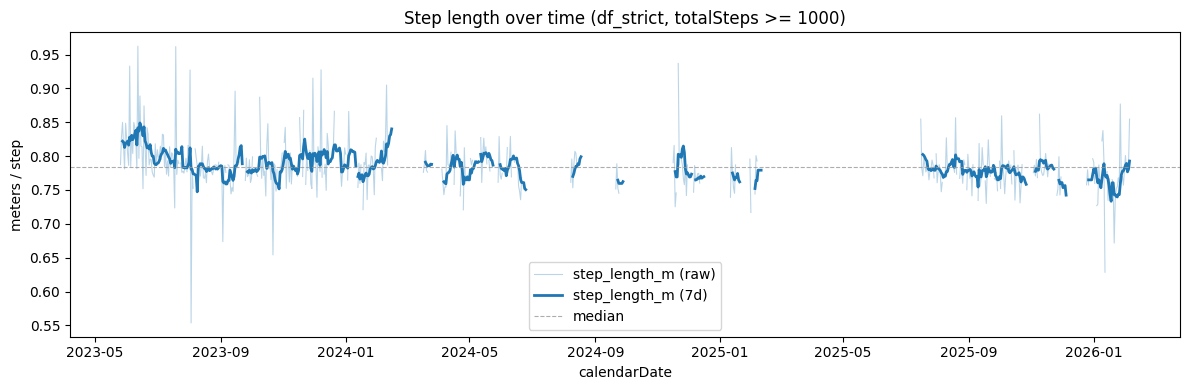

In [8]:
if not all(c in df_strict.columns for c in ['totalSteps', 'totalDistanceMeters']):
    print('Skip: missing totalSteps / totalDistanceMeters for step length')
else:
    step_df = df_strict[['calendarDate', 'totalSteps', 'totalDistanceMeters']].copy()
    step_df['calendarDate'] = pd.to_datetime(step_df['calendarDate'], errors='coerce').dt.normalize()
    step_df['totalSteps'] = pd.to_numeric(step_df['totalSteps'], errors='coerce')
    step_df['totalDistanceMeters'] = pd.to_numeric(step_df['totalDistanceMeters'], errors='coerce')
    step_df = step_df[(step_df['totalSteps'] >= 1000) & step_df['totalDistanceMeters'].notna()].copy()
    if step_df.empty:
        print('Skip: no rows with totalSteps >= 1000')
    else:
        step_df['step_length_m'] = step_df['totalDistanceMeters'] / step_df['totalSteps']
        fig, ax = plt.subplots(figsize=(12, 4))
        s = plot_ts_with_gaps(ax, step_df, 'calendarDate', 'step_length_m', label='step_length_m (raw)', rolling_days=None)
        if s.empty:
            print('Skip: no plottable step_length_m')
            plt.close(fig)
        else:
            r = s.rolling(7, min_periods=3).mean()
            ax.plot(s.index, r.values, color='#1f77b4', lw=ROLL_LW, label='step_length_m (7d)')
            for line in ax.lines[:-1]:
                if line.get_label() == 'step_length_m (raw)':
                    line.set_alpha(RAW_ALPHA_DEFAULT)
                    line.set_linewidth(RAW_LW)
                    line.set_color('#1f77b4')
            ax.axhline(step_df['step_length_m'].median(), color='#999999', lw=0.8, ls='--', alpha=0.8, label='median')
            ax.set_title('Step length over time (df_strict, totalSteps >= 1000)')
            ax.set_xlabel('calendarDate')
            ax.set_ylabel('meters / step')
            ax.legend(loc='best')
            fig.tight_layout()
            maybe_save(fig, 'step_length_strict_steps_ge_1000')
            plt.show()


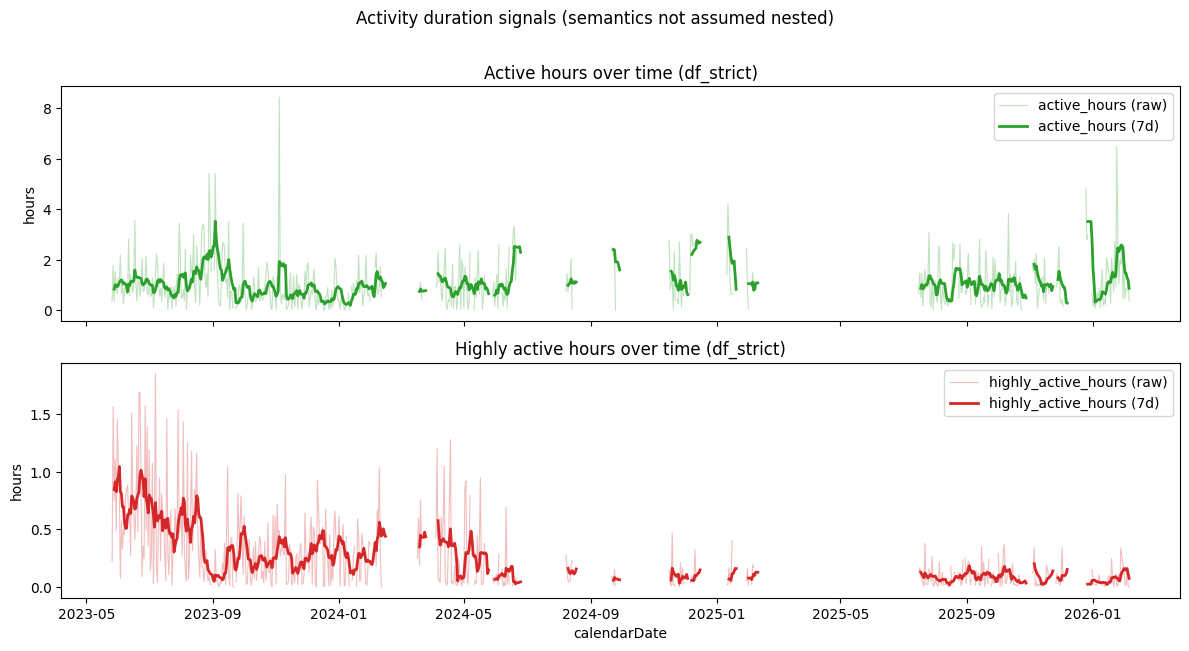

In [9]:
needed = [c for c in ['activeSeconds', 'highlyActiveSeconds'] if c in df_strict.columns]
if not needed:
    print('Skip: missing activeSeconds/highlyActiveSeconds')
else:
    fig, axes = plt.subplots(len(needed), 1, figsize=(12, 3.2 * len(needed)), sharex=True)
    if len(needed) == 1:
        axes = [axes]

    panel_meta = {
        'activeSeconds': ('Active hours over time (df_strict)', '#2ca02c', 'active_hours'),
        'highlyActiveSeconds': ('Highly active hours over time (df_strict)', '#d62728', 'highly_active_hours'),
    }
    for ax, col in zip(axes, needed):
        tmp = df_strict[['calendarDate', col]].copy()
        tmp[col] = pd.to_numeric(tmp[col], errors='coerce') / 3600.0
        title, color, label = panel_meta[col]
        s = plot_ts_with_gaps(ax, tmp, 'calendarDate', col, label=f'{label} (raw)', rolling_days=None)
        if s.empty:
            ax.set_title(f'Skip: no plottable data for {col}')
            continue
        r = s.rolling(7, min_periods=3).mean()
        ax.plot(s.index, r.values, color=color, lw=ROLL_LW, label=f'{label} (7d)')
        for line in ax.lines[:-1]:
            line.set_alpha(RAW_ALPHA_DEFAULT)
            line.set_linewidth(RAW_LW)
            line.set_color(color)
        ax.set_title(title)
        ax.set_ylabel('hours')
        ax.legend(loc='best')

    axes[-1].set_xlabel('calendarDate')
    fig.suptitle('Activity duration signals (semantics not assumed nested)', y=1.01)
    fig.tight_layout()
    maybe_save(fig, 'activity_hours_compare_strict')
    plt.show()


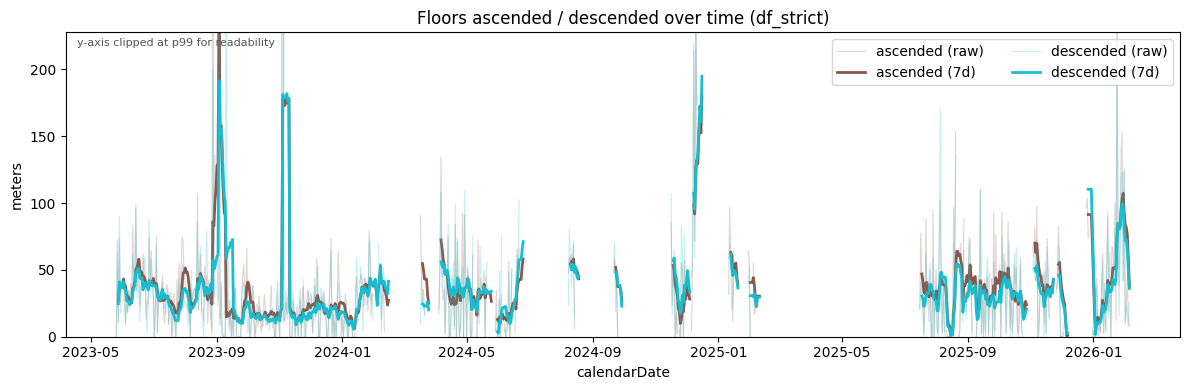

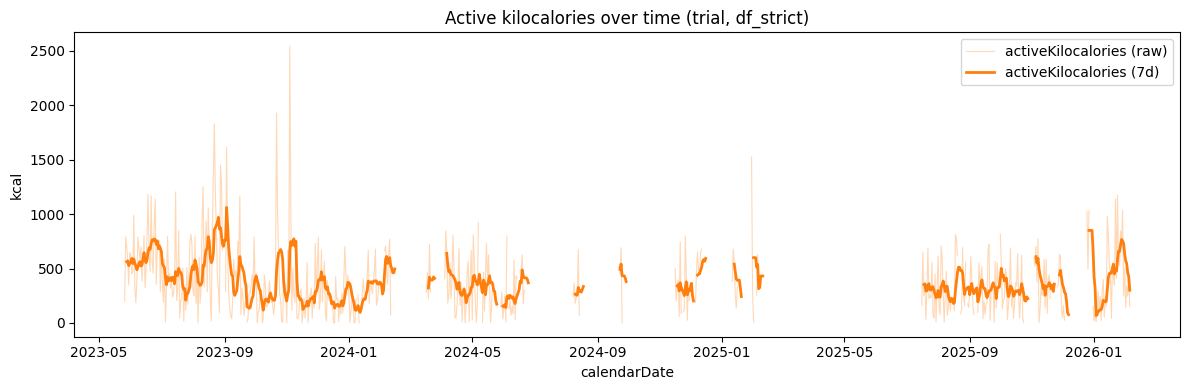

In [10]:
# Secondary activity diagnostics (trial): floors and active kcal.
if all(c in df_strict.columns for c in ['floorsAscendedInMeters', 'floorsDescendedInMeters']):
    floor_df = _ts_numeric_frame(df_strict, ['floorsAscendedInMeters', 'floorsDescendedInMeters'])
    fig, ax = plt.subplots(figsize=(12, 4))
    for col, color, label in [
        ('floorsAscendedInMeters', '#8c564b', 'ascended'),
        ('floorsDescendedInMeters', '#17becf', 'descended'),
    ]:
        s = plot_ts_with_gaps(ax, floor_df, 'calendarDate', col, label=f'{label} (raw)', rolling_days=None)
        if s.empty:
            continue
        ax.plot(s.index, s.rolling(7, min_periods=3).mean().values, color=color, lw=ROLL_LW, label=f'{label} (7d)')
        for line in ax.lines[:-1]:
            if line.get_label() == f'{label} (raw)':
                line.set_alpha(RAW_ALPHA_DENSE)
                line.set_linewidth(RAW_LW)
                line.set_color(color)
    # Robust y-limit keeps the bulk visible while a few extreme peaks remain clipped.
    floor_vals = pd.concat([floor_df['floorsAscendedInMeters'], floor_df['floorsDescendedInMeters']], ignore_index=True)
    floor_vals = pd.to_numeric(floor_vals, errors='coerce').dropna()
    if not floor_vals.empty:
        robust_upper = float(floor_vals.quantile(0.99)) * 1.05
        full_upper = float(floor_vals.max())
        if robust_upper > 0 and full_upper > robust_upper * 1.1:
            ax.set_ylim(0, robust_upper)
            ax.text(0.01, 0.98, 'y-axis clipped at p99 for readability', transform=ax.transAxes, ha='left', va='top', fontsize=8, color='#555555')
    ax.set_title('Floors ascended / descended over time (df_strict)')
    ax.set_xlabel('calendarDate')
    ax.set_ylabel('meters')
    ax.legend(loc='best', ncol=2)
    fig.tight_layout()
    maybe_save(fig, 'floors_asc_desc_strict')
    plt.show()
else:
    print('Skip floors diagnostic: missing floorsAscendedInMeters/floorsDescendedInMeters')

if 'activeKilocalories' in df_strict.columns:
    kcal_df = _ts_numeric_frame(df_strict, ['activeKilocalories'])
    fig, ax = plt.subplots(figsize=(12, 4))
    s = plot_ts_with_gaps(ax, kcal_df, 'calendarDate', 'activeKilocalories', label='activeKilocalories (raw)', rolling_days=None)
    if s.empty:
        print('Skip: no plottable activeKilocalories')
        plt.close(fig)
    else:
        ax.plot(s.index, s.rolling(7, min_periods=3).mean().values, color='#ff7f0e', lw=ROLL_LW, label='activeKilocalories (7d)')
        for line in ax.lines[:-1]:
            if line.get_label() == 'activeKilocalories (raw)':
                line.set_alpha(RAW_ALPHA_DEFAULT)
                line.set_linewidth(RAW_LW)
                line.set_color('#ff7f0e')
        ax.set_title('Active kilocalories over time (trial, df_strict)')
        ax.set_xlabel('calendarDate')
        ax.set_ylabel('kcal')
        ax.legend(loc='best')
        fig.tight_layout()
        maybe_save(fig, 'active_kcal_strict_trial')
        plt.show()
else:
    print('Skip active kcal trial: missing activeKilocalories')


### Activity findings

- `totalSteps` remains the primary movement-volume signal for time-series review.
- `step_length_m` (thresholded by step count) adds non-redundant information versus distance and is useful as a tempo / movement-mode proxy.
- `activeSeconds` and `highlyActiveSeconds` are compared side-by-side without assuming one is nested inside the other.


## Stress

Stress metrics are split into `TOTAL`, `AWAKE`, and `ASLEEP` contexts. These should not be conflated.

What we inspect here:
- average stress level over time (context comparison)
- composition of measured time using stress duration shares (`rest/low/med/high/activity/uncat`)

Notes:
- `stressTotalDurationSeconds` is mainly a coverage / denominator signal (used earlier in Quality context)
- negative `ASLEEP_averageStressLevel` values (e.g. `-2`) are treated as invalid sentinels and excluded from plots


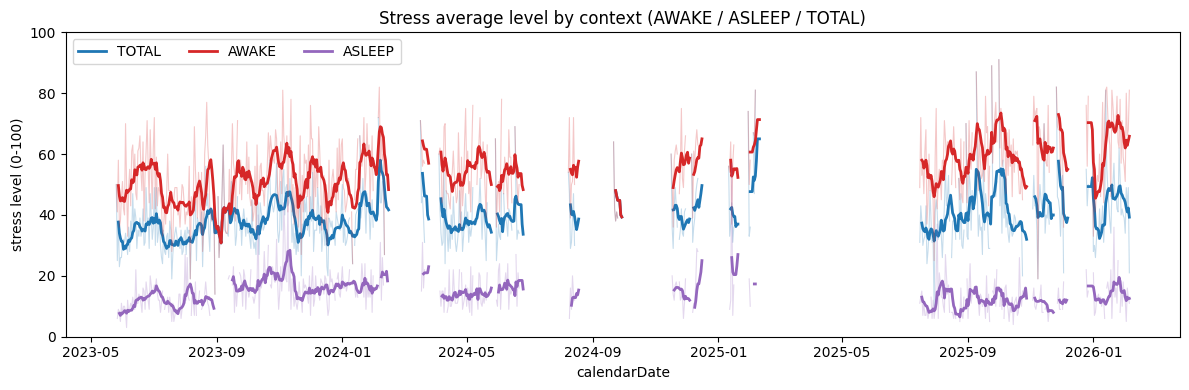

In [11]:
series_specs = [
    ('allDayStress_TOTAL_averageStressLevel', 'TOTAL', '#1f77b4', df_strict),
    ('allDayStress_AWAKE_averageStressLevel', 'AWAKE', '#d62728', df_strict),
    ('allDayStress_ASLEEP_averageStressLevel', 'ASLEEP', '#9467bd', df_sleep),
]

available = [(c, label, color, frame) for (c, label, color, frame) in series_specs if c in frame.columns]
if not available:
    print('Skip: missing stress average level columns (TOTAL/AWAKE/ASLEEP)')
else:
    fig, ax = plt.subplots(figsize=(12, 4))
    plotted = False
    for col, label, color, frame in available:
        tmp = frame[['calendarDate', col]].copy()
        tmp['calendarDate'] = pd.to_datetime(tmp['calendarDate'], errors='coerce').dt.normalize()
        tmp[col] = pd.to_numeric(tmp[col], errors='coerce')
        if label == 'ASLEEP':
            tmp.loc[tmp[col] < 0, col] = np.nan  # Garmin sentinel values (e.g. -2)
        tmp = tmp.dropna(subset=['calendarDate']).sort_values('calendarDate')
        if tmp.empty:
            continue
        idx = pd.date_range(tmp['calendarDate'].min(), tmp['calendarDate'].max(), freq='D')
        s = tmp.set_index('calendarDate')[col].astype(float).reindex(idx)
        if s.empty:
            continue
        plotted = True
        ax.plot(idx, s.values, color=color, lw=RAW_LW, alpha=RAW_ALPHA_DENSE)
        ax.plot(idx, s.rolling(7, min_periods=3).mean().values, color=color, lw=ROLL_LW, label=label)

    if not plotted:
        print('Skip: no plottable stress average level series')
        plt.close(fig)
    else:
        ax.set_ylim(0, 100)
        ax.set_title('Stress average level by context (AWAKE / ASLEEP / TOTAL)')
        ax.set_xlabel('calendarDate')
        ax.set_ylabel('stress level (0-100)')
        ax.legend(loc='upper left', ncol=3)
        fig.tight_layout()
        maybe_save(fig, 'stress_avg_context_compare')
        plt.show()


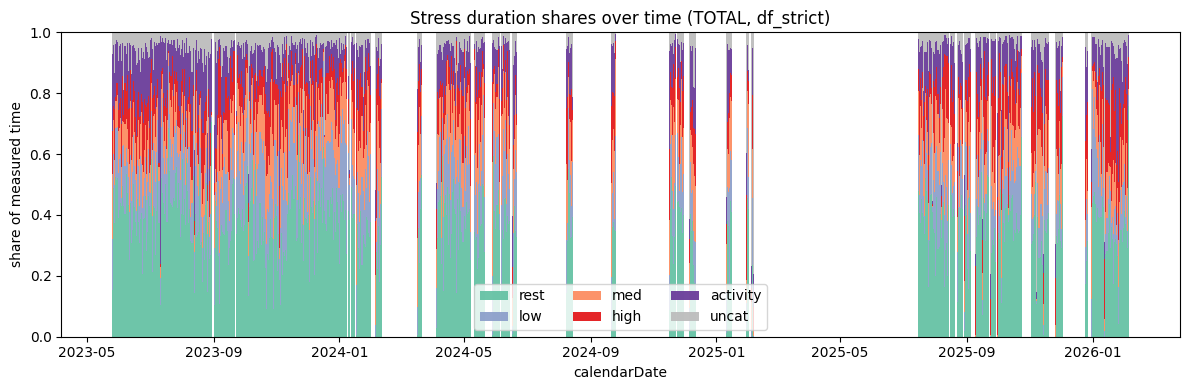

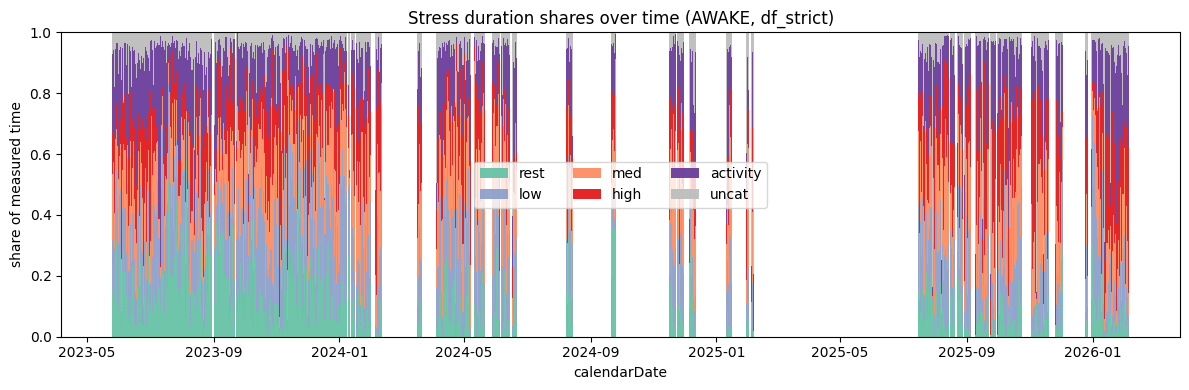

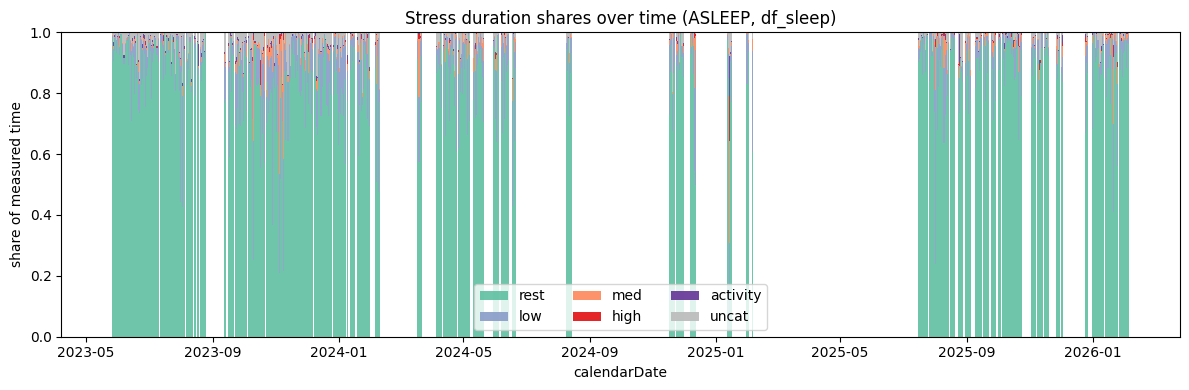

In [12]:
def _stress_context_share_plot(frame: pd.DataFrame, context: str, *, save_name: str):
    suffix = context.upper()
    dur_candidates = {
        'rest': _find_col(frame, f'allDayStress_{suffix}_restDuration'),
        'low': _find_col(frame, f'allDayStress_{suffix}_lowDuration'),
        'med': _find_col(frame, f'allDayStress_{suffix}_mediumDuration'),
        'high': _find_col(frame, f'allDayStress_{suffix}_highDuration'),
        'activity': _find_col(frame, f'allDayStress_{suffix}_activityDuration'),
        'uncat': _find_col(frame, f'allDayStress_{suffix}_uncategorizedDuration'),
    }
    total_col = _find_col(frame, f'allDayStress_{suffix}_totalDuration')

    if total_col is None or any(v is None for v in dur_candidates.values()):
        print(f'Skip: missing stress duration columns for context={suffix}')
        return

    stress_df = frame[['calendarDate', total_col, *dur_candidates.values()]].copy()
    stress_df['calendarDate'] = pd.to_datetime(stress_df['calendarDate'], errors='coerce').dt.normalize()
    stress_df = stress_df.dropna(subset=['calendarDate'])
    for col in [total_col, *dur_candidates.values()]:
        stress_df[col] = pd.to_numeric(stress_df[col], errors='coerce')

    stress_df = stress_df[stress_df[total_col] > 0].copy()
    if suffix == 'ASLEEP':
        # ASLEEP context is often missing; keep plot only if we still have enough rows.
        stress_df = stress_df.dropna(subset=list(dur_candidates.values()), how='all')
    if stress_df.empty:
        print(f'Skip: no rows with positive total duration for context={suffix}')
        return

    shares = pd.DataFrame({'calendarDate': stress_df['calendarDate']})
    for label, col in dur_candidates.items():
        shares[label] = stress_df[col] / stress_df[total_col]

    fig, ax = plt.subplots(figsize=(12, 4))
    bottom = np.zeros(len(shares), dtype=float)
    color_map = {
        'rest': '#66c2a5',
        'low': '#8da0cb',
        'med': '#fc8d62',
        'high': '#e31a1c',
        'activity': '#6a3d9a',
        'uncat': '#bdbdbd',
    }
    for label in ['rest', 'low', 'med', 'high', 'activity', 'uncat']:
        vals = pd.to_numeric(shares[label], errors='coerce').fillna(0.0).to_numpy()
        ax.bar(
            shares['calendarDate'],
            vals,
            bottom=bottom,
            width=1.0,
            align='center',
            label=label,
            color=color_map[label],
            alpha=0.95,
        )
        bottom = bottom + vals

    ax.set_ylim(0, 1)
    ax.set_title(f'Stress duration shares over time ({suffix}, df_strict)' if suffix != 'ASLEEP' else 'Stress duration shares over time (ASLEEP, df_sleep)')
    ax.set_xlabel('calendarDate')
    ax.set_ylabel('share of measured time')
    ax.legend(loc='best', ncol=3)
    fig.tight_layout()
    maybe_save(fig, save_name)
    plt.show()

# TOTAL and AWAKE are core; ASLEEP is informative but may be sparse / partial.
_stress_context_share_plot(df_strict, 'TOTAL', save_name='stress_breakdown_shares_total_strict')
_stress_context_share_plot(df_strict, 'AWAKE', save_name='stress_breakdown_shares_awake_strict')
_stress_context_share_plot(df_sleep, 'ASLEEP', save_name='stress_breakdown_shares_asleep_sleep')


### Stress findings

- `TOTAL`, `AWAKE`, and `ASLEEP` average stress are interpreted separately because sleep and wake stress carry different meanings.
- Stress composition is plotted in shares (not raw durations) so days remain comparable when measured duration changes.


## Heart rate

Use a compact, interpretable view first: `minHeartRate`, `maxHeartRate`, and `restingHeartRate` on one chart.
Less obvious Garmin HR variants (`minAvgHeartRate`, `maxAvgHeartRate`, `currentDayRestingHeartRate`) are treated as diagnostics unless they add clear value.

Note: the current parsed daily table does not expose a plain `averageHeartRate` field; this section centers on min/resting/max, with Garmin-specific variants treated as diagnostics.


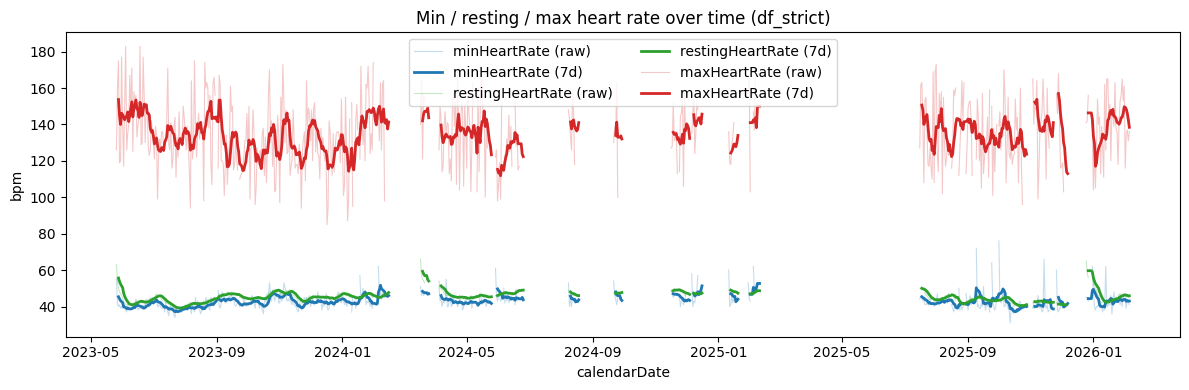

In [13]:
heart_cols = [c for c in ['minHeartRate', 'maxHeartRate', 'restingHeartRate'] if c in df_strict.columns]
if len(heart_cols) < 2:
    print('Skip: missing key heart-rate columns')
else:
    fig, ax = plt.subplots(figsize=(12, 4))
    colors = {
        'minHeartRate': '#1f77b4',
        'restingHeartRate': '#2ca02c',
        'maxHeartRate': '#d62728',
    }
    for col in ['minHeartRate', 'restingHeartRate', 'maxHeartRate']:
        if col not in heart_cols:
            continue
        s = plot_ts_with_gaps(ax, df_strict, 'calendarDate', col, label=f'{col} (raw)', rolling_days=None)
        if s.empty:
            continue
        r = s.rolling(7, min_periods=3).mean()
        ax.plot(s.index, r.values, color=colors[col], lw=ROLL_LW, label=f'{col} (7d)')
        for line in ax.lines[:-1]:
            if line.get_label() == f'{col} (raw)':
                line.set_color(colors[col])
                line.set_alpha(RAW_ALPHA_DENSE)
                line.set_linewidth(RAW_LW)

    ax.set_title('Min / resting / max heart rate over time (df_strict)')
    ax.set_xlabel('calendarDate')
    ax.set_ylabel('bpm')
    ax.legend(loc='best', ncol=2)
    fig.tight_layout()
    maybe_save(fig, 'heart_min_resting_max_strict')
    plt.show()


In [14]:
diagnostic_cols = [c for c in ['restingHeartRate', 'currentDayRestingHeartRate'] if c in df_strict.columns]
if len(diagnostic_cols) < 2:
    print('Diagnostic skip: currentDayRestingHeartRate not available')
else:
    hr_diag = df_strict[['calendarDate', *diagnostic_cols]].copy()
    for col in diagnostic_cols:
        hr_diag[col] = pd.to_numeric(hr_diag[col], errors='coerce')
    hr_diag['rhr_delta'] = hr_diag['currentDayRestingHeartRate'] - hr_diag['restingHeartRate']
    display(
        hr_diag[['restingHeartRate', 'currentDayRestingHeartRate', 'rhr_delta']]
        .describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
        .T
    )


,count,mean,std,min,5%,25%,50%,75%,95%,max
restingHeartRate,524.0,45.177481,3.168467,39.0,41.0,43.0,45.0,47.0,49.0,66.0
currentDayRestingHeartRate,524.0,44.875954,3.630374,36.0,39.0,43.0,45.0,47.0,51.0,66.0
rhr_delta,524.0,-0.301527,2.798647,-16.0,-5.0,-2.0,0.0,2.0,4.0,6.0


## Body Battery

Garmin Body Battery is a modeled daily energy signal (0-100) and is useful as a proxy, but daily alignment needs care.
Charging often happens during sleep in the early hours of the calendar day, so interpret these as within-day charge/drain dynamics.


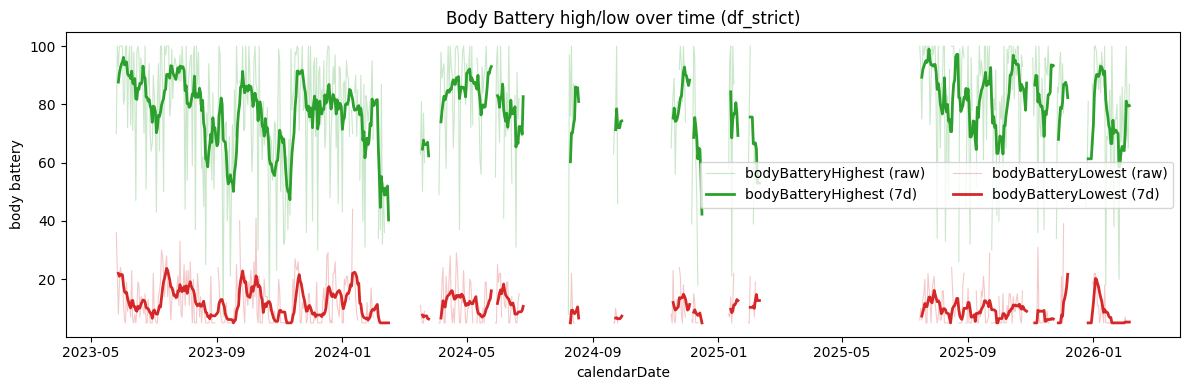

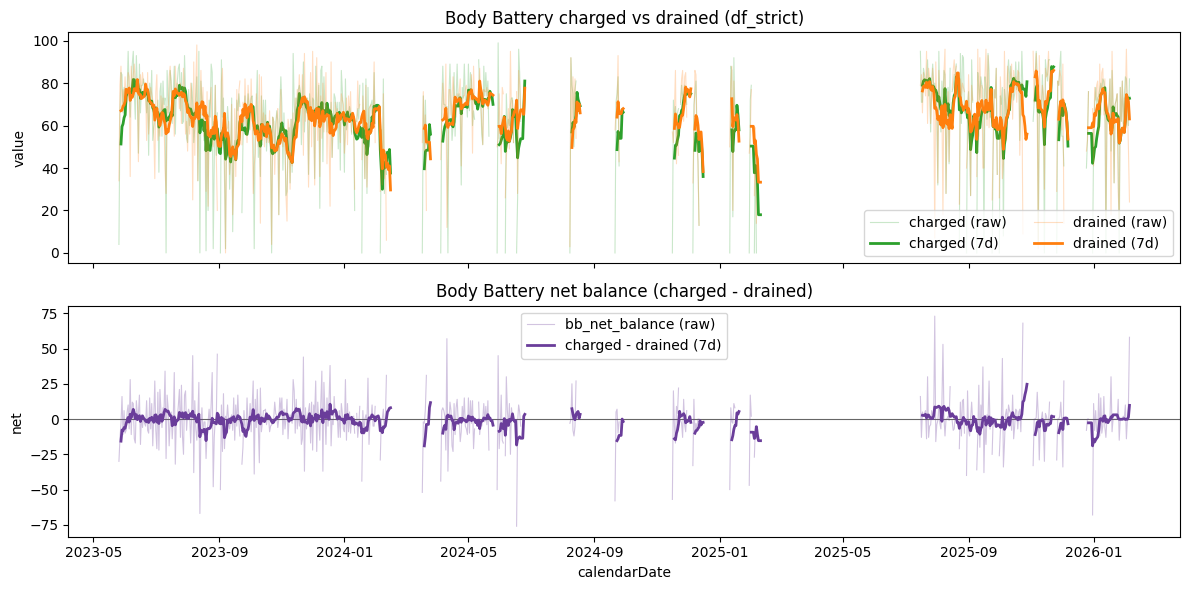

In [15]:
bb_high_col = _find_col(df_strict, 'bodyBatteryHighest', 'bodyBatteryHighest')
bb_low_col = _find_col(df_strict, 'bodyBatteryLowest', 'bodyBatteryLowest')

if bb_high_col is None or bb_low_col is None:
    print('Skip: missing bodyBatteryHighest or bodyBatteryLowest')
else:
    bb_df = _ts_numeric_frame(df_strict, [bb_high_col, bb_low_col])

    fig, ax = plt.subplots(figsize=(12, 4))
    colors = {bb_high_col: '#2ca02c', bb_low_col: '#d62728'}
    for col, label in [(bb_high_col, 'bodyBatteryHighest'), (bb_low_col, 'bodyBatteryLowest')]:
        s = plot_ts_with_gaps(ax, bb_df, 'calendarDate', col, label=f'{label} (raw)', rolling_days=None)
        if s.empty:
            continue
        ax.plot(s.index, s.rolling(7, min_periods=3).mean().values, color=colors[col], lw=ROLL_LW, label=f'{label} (7d)')
        for line in ax.lines[:-1]:
            if line.get_label() == f'{label} (raw)':
                line.set_alpha(RAW_ALPHA_DENSE)
                line.set_linewidth(RAW_LW)
                line.set_color(colors[col])
    ax.set_title('Body Battery high/low over time (df_strict)')
    ax.set_xlabel('calendarDate')
    ax.set_ylabel('body battery')
    ax.legend(loc='best', ncol=2)
    fig.tight_layout()
    maybe_save(fig, 'bodybattery_high_low_strict')
    plt.show()

charged_col = _find_col(df_strict, 'bodyBattery_chargedValue', 'bodyBatteryChargedValue')
drained_col = _find_col(df_strict, 'bodyBattery_drainedValue', 'bodyBatteryDrainedValue')
if charged_col is None or drained_col is None:
    print('Skip: missing bodyBattery charged/drained columns')
else:
    cd_df = _ts_numeric_frame(df_strict, [charged_col, drained_col])
    cd_df['bb_net_balance'] = cd_df[charged_col] - cd_df[drained_col]

    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    for col, label, color in [
        (charged_col, 'charged', '#2ca02c'),
        (drained_col, 'drained', '#ff7f0e'),
    ]:
        s = plot_ts_with_gaps(axes[0], cd_df, 'calendarDate', col, label=f'{label} (raw)', rolling_days=None)
        if s.empty:
            continue
        axes[0].plot(s.index, s.rolling(7, min_periods=3).mean().values, color=color, lw=ROLL_LW, label=f'{label} (7d)')
        for line in axes[0].lines[:-1]:
            if line.get_label() == f'{label} (raw)':
                line.set_alpha(RAW_ALPHA_DENSE)
                line.set_linewidth(RAW_LW)
                line.set_color(color)
    axes[0].set_title('Body Battery charged vs drained (df_strict)')
    axes[0].set_ylabel('value')
    axes[0].legend(loc='best', ncol=2)

    s_net = plot_ts_with_gaps(axes[1], cd_df, 'calendarDate', 'bb_net_balance', label='bb_net_balance (raw)', rolling_days=None)
    if not s_net.empty:
        axes[1].axhline(0, color='#666666', lw=0.8, zorder=0)
        axes[1].plot(s_net.index, s_net.rolling(7, min_periods=3).mean().values, color='#6a3d9a', lw=ROLL_LW, label='charged - drained (7d)')
        for line in axes[1].lines[:-1]:
            if line.get_label() == 'bb_net_balance (raw)':
                line.set_alpha(RAW_ALPHA_DEFAULT)
                line.set_linewidth(RAW_LW)
                line.set_color('#6a3d9a')
    axes[1].set_title('Body Battery net balance (charged - drained)')
    axes[1].set_ylabel('net')
    axes[1].set_xlabel('calendarDate')
    axes[1].legend(loc='best')

    fig.tight_layout()
    maybe_save(fig, 'bodybattery_charged_drained_and_net_strict')
    plt.show()


### Heart + Body Battery findings

- Heart-rate overview uses a compact min/resting/max layout because a plain daily average HR is not available in the current parsed table.
- Body Battery is treated as a modeled daily energy proxy; charged/drained plus net balance help interpret daily dynamics across days.


## Sleep timeseries

Sleep charts use `df_sleep` (sleep-covered, non-corrupted days). Coverage is intentionally narrower than `df_strict`.
This section focuses on timing, duration, composition, scores, respiration/SpO2, and sleep-specific stress.

Sleep interval chart notes:
- interval colors use `sleepOverallScore` buckets: poor `<60`, fair `60-79`, good `80-89`, excellent `90-100` (Garmin labels)
- local time is derived from Garmin per-day `wellness*TimeGmt/Local` offsets when available (travel-aware), with fallback to system-local conversion


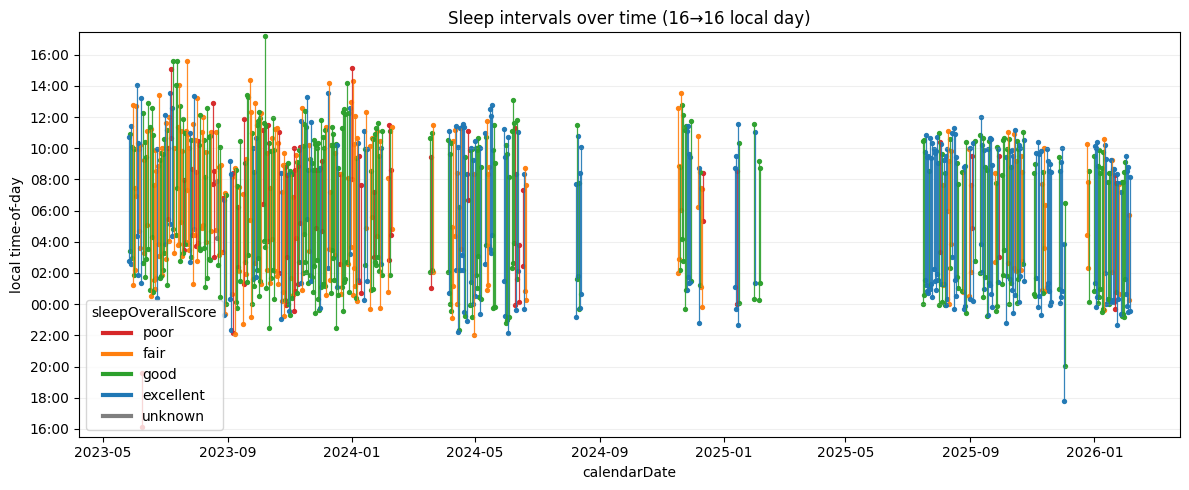

In [16]:
plot_sleep_intervals(
    df_sleep,
    anchor_hour=16,
    score_col='sleepOverallScore',
    stick_lw=0.9,
    marker_size=8.0,
    save_figs=SAVE_FIGS,
    fig_dir=FIG_DIR,
)


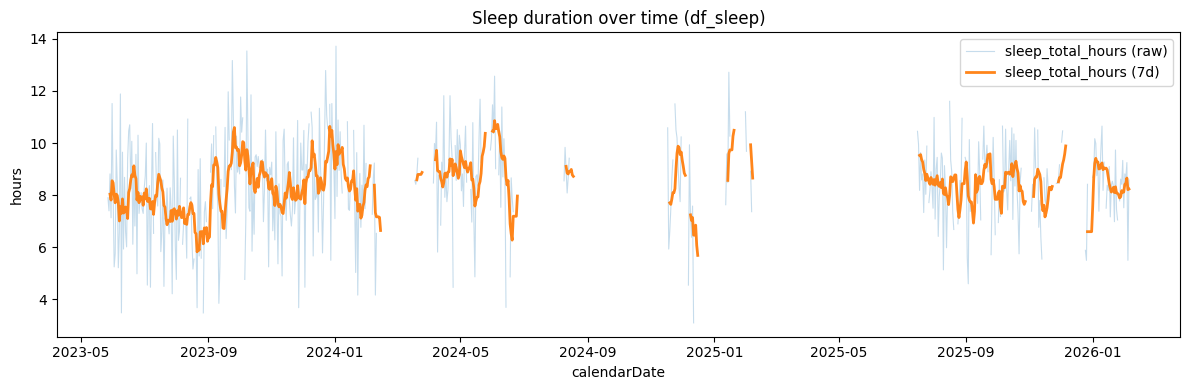

In [17]:
# Baseline sleep duration timeseries (clean view)
plot_sleep_duration(
    df_sleep,
    save_figs=SAVE_FIGS,
    fig_dir=FIG_DIR,
)


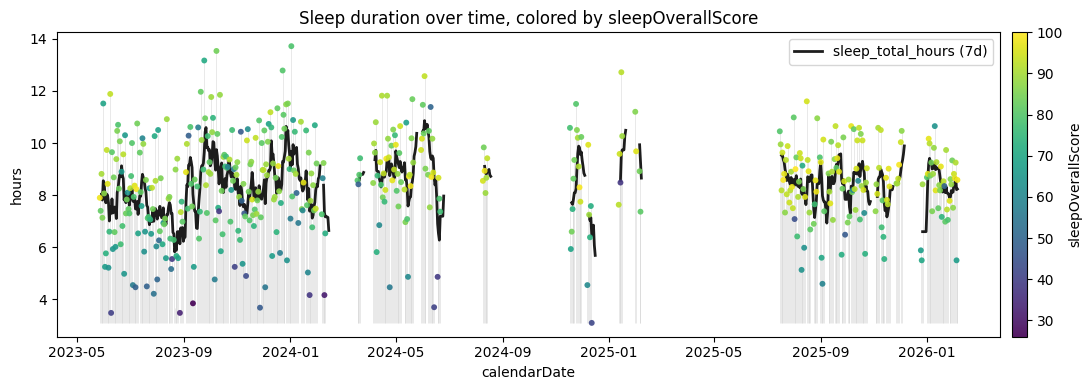

In [18]:
# Alternate view for hypothesis generation: duration points colored by sleep score.
plot_sleep_duration_scored(
    df_sleep,
    score_col='sleepOverallScore',
    rolling_days=7,
    save_figs=SAVE_FIGS,
    fig_dir=FIG_DIR,
)


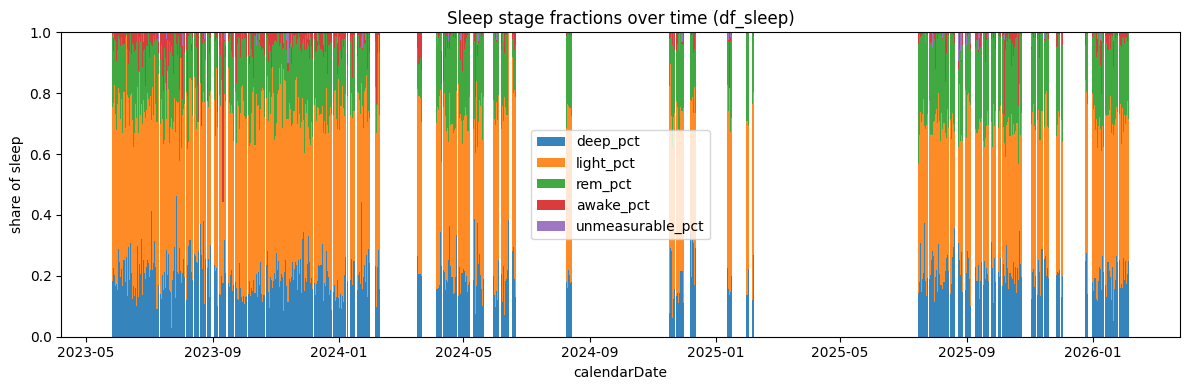

In [19]:
plot_sleep_stage_fractions(
    df_sleep,
    save_figs=SAVE_FIGS,
    fig_dir=FIG_DIR,
)

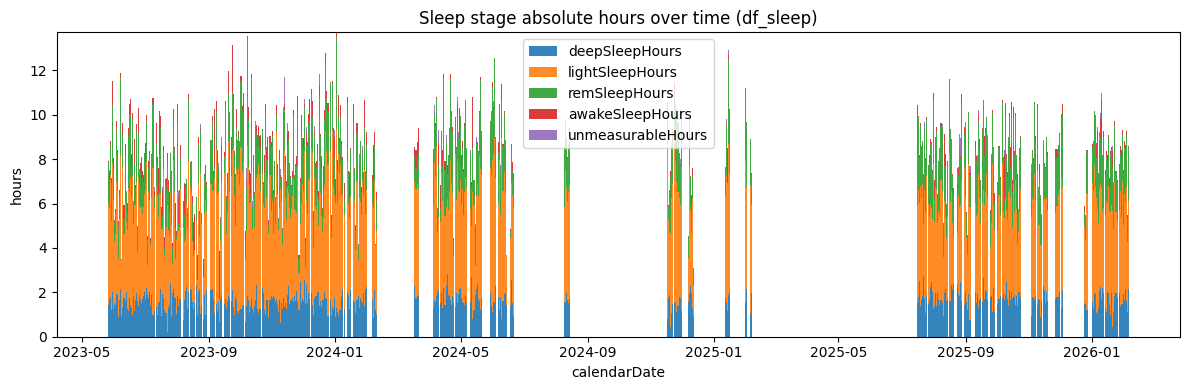

In [20]:
plot_sleep_stage_hours(
    df_sleep,
    save_figs=SAVE_FIGS,
    fig_dir=FIG_DIR,
)

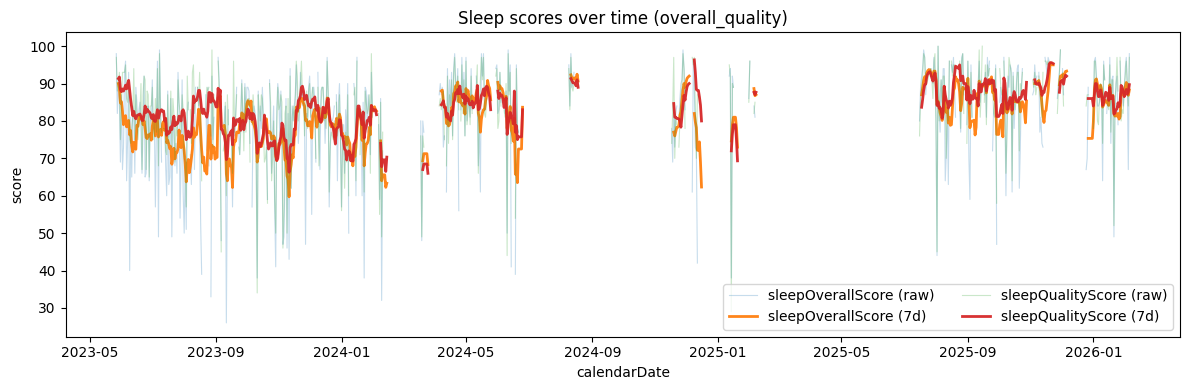

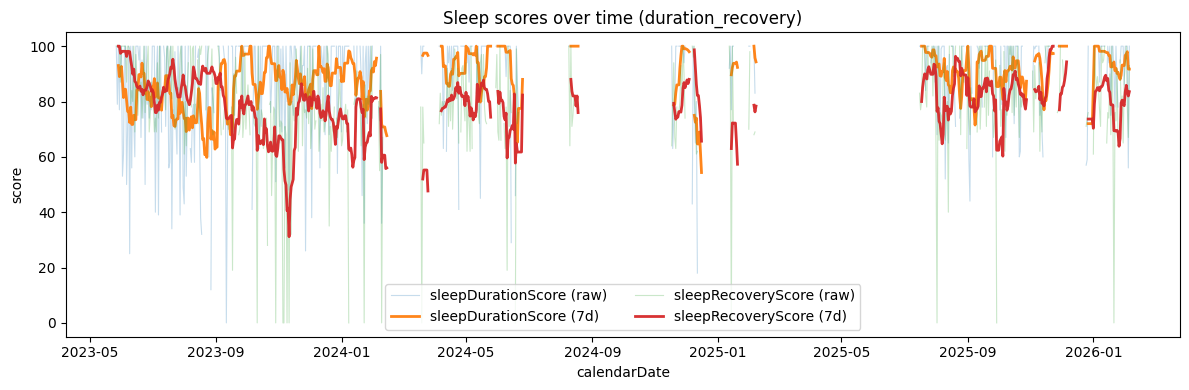

In [21]:
plot_sleep_scores(
    df_sleep,
    rolling_days=7,
    save_figs=SAVE_FIGS,
    fig_dir=FIG_DIR,
)

### Sleep respiration, SpO2, and sleep stress

Respiration and SpO2 are treated as exploratory wearable signals (hypothesis-generating, not medical diagnostics).


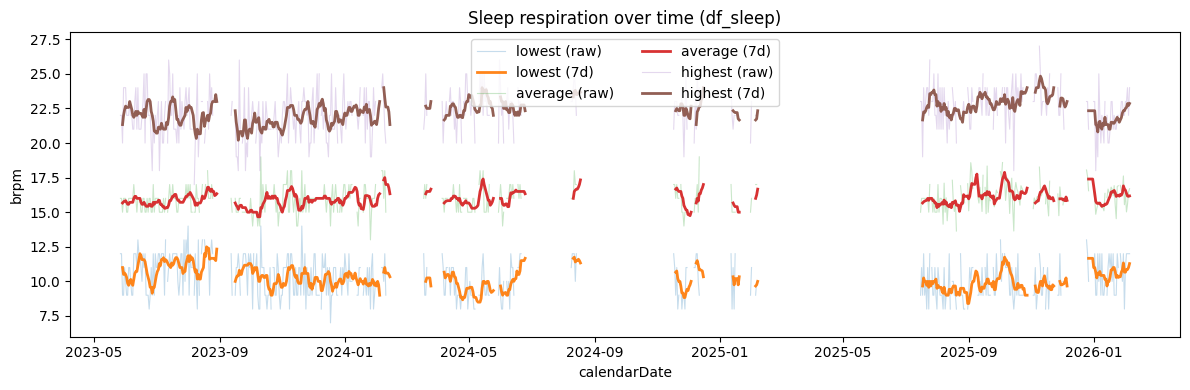

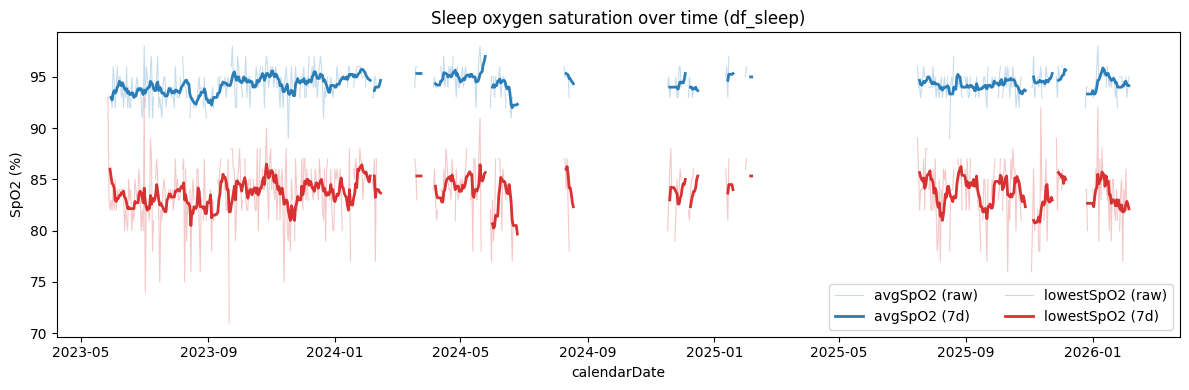

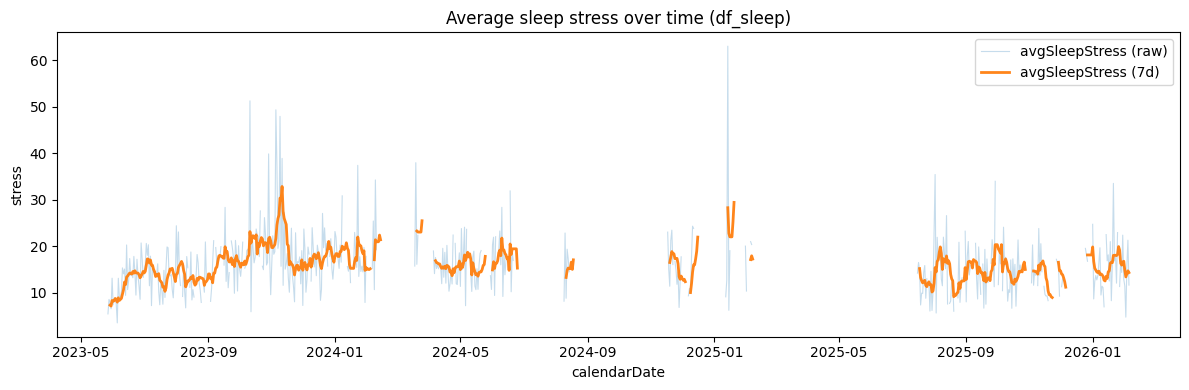

In [22]:
plot_sleep_respiration(
    df_sleep,
    rolling_days=7,
    save_figs=SAVE_FIGS,
    fig_dir=FIG_DIR,
)

plot_sleep_spo2(
    df_sleep,
    rolling_days=7,
    save_figs=SAVE_FIGS,
    fig_dir=FIG_DIR,
)

plot_sleep_stress(
    df_sleep,
    rolling_days=7,
    save_figs=SAVE_FIGS,
    fig_dir=FIG_DIR,
)


### Sleep findings

- Sleep section combines timing, duration, composition, scores, respiration/SpO2, and `avgSleepStress` on the `df_sleep` slice.
- The score-colored sleep duration chart is used for hypothesis generation (associations), not causal claims.
